# R mixed effect modeling tutorial

**Original code: https://github.com/ourcodingclub/CC-Linear-mixed-models**

**Original post: https://ourcodingclub.github.io/tutorials/mixed-models/**

authors: Gabriela K Hajduk, based on workshop developed by Liam Bailey

contact details: gkhajduk.github.io; email: gkhajduk@gmail.com

date: 2017-03-09

Created by Gabriela K Hajduk - last updated 9th February 2022 by Elise Gallois

This work is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/).

*Revised and adapted by Andrew Chang (Feb 3, 2023)*

# 1. What is mixed effects modelling and why does it matter?
Ecological and biological data are often complex and messy. We can have different **grouping factors** like populations, species, sites where we collect the data, etc. Sample sizes might leave something to be desired too, especially if we are trying to fit complicated models with **many parameters**. On top of that, our data points might not be truly independent. For instance, we might be using quadrats within our sites to collect the data (and so there is structure to our data: quadrats are nested within the sites).

This is why **mixed models** were developed, to deal with such messy data and to allow us to use all our data, even when we have low sample sizes, structured data and many covariates to fit. Oh, and on top of all that, mixed models allow us to save degrees of freedom compared to running standard linear models! Sounds good, doesn’t it?

We will cover only linear mixed models here, but if you are trying to “extend” your linear model, fear not: there are generalised linear mixed effects models out there, too.

# 2. Data exploration

load the data and have a look at it

In [1]:
load("dragons.RData")
head(dragons)

,testScore,bodyLength,mountainRange,X,site
,<dbl>,<dbl>,<fct>,<lgl>,<fct>
1,16.147309,165.5485,Bavarian,NA,a
2,33.886183,167.5593,Bavarian,NA,a
3,6.038333,165.8830,Bavarian,NA,a
4,18.838821,167.6855,Bavarian,NA,a
5,33.862328,169.9597,Bavarian,NA,a
6,47.043246,168.6887,Bavarian,NA,a


Let's say we want to know how the body length affects test scores.

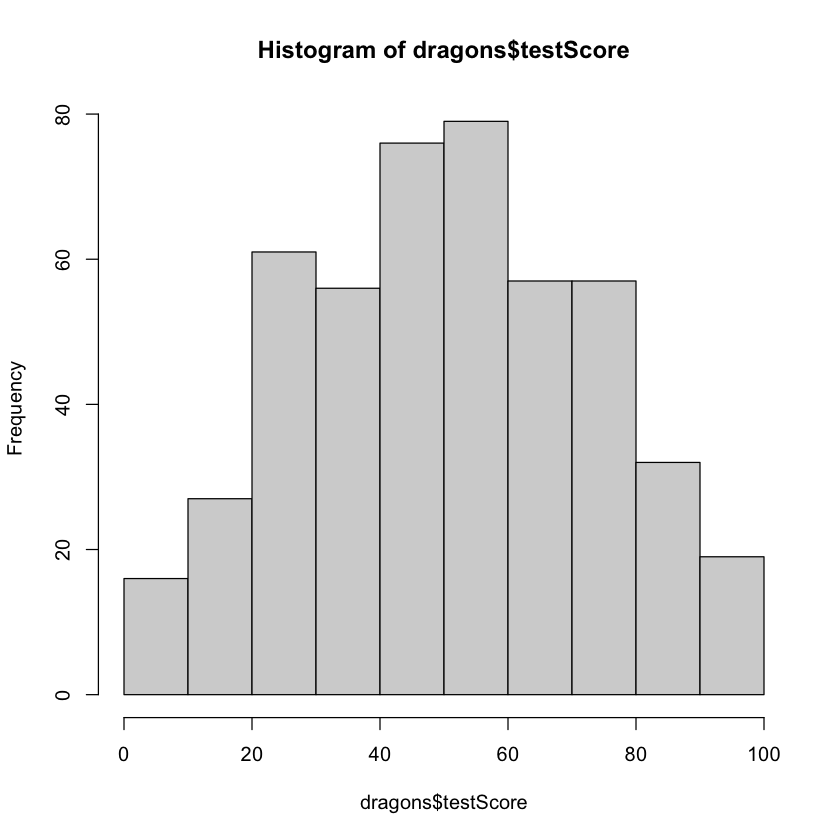

In [2]:
## Have a look at the data distribution:

hist(dragons$testScore)  # seems close to normal distribution - good!

In [3]:
## You can standardize your explanatory variables before proceeding - you can use scale() to do that:
dragons$bodyLength2 <- scale(dragons$bodyLength, center = TRUE, scale = TRUE)

# 3. Fit all data in one analysis

One way to analyse this data would be to try fitting a linear model to all our data, ignoring the sites and the mountain ranges for now.

In [4]:
basic.lm <- lm(testScore ~ bodyLength2, data = dragons)
summary(basic.lm)


Call:
lm(formula = testScore ~ bodyLength2, data = dragons)

Residuals:
    Min      1Q  Median      3Q     Max 
-56.962 -16.411  -0.783  15.193  55.200 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  50.3860     0.9676  52.072   <2e-16 ***
bodyLength2   8.9956     0.9686   9.287   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.2 on 478 degrees of freedom
Multiple R-squared:  0.1529,	Adjusted R-squared:  0.1511 
F-statistic: 86.25 on 1 and 478 DF,  p-value: < 2.2e-16


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
`geom_smooth()` using formula = 'y ~ x'


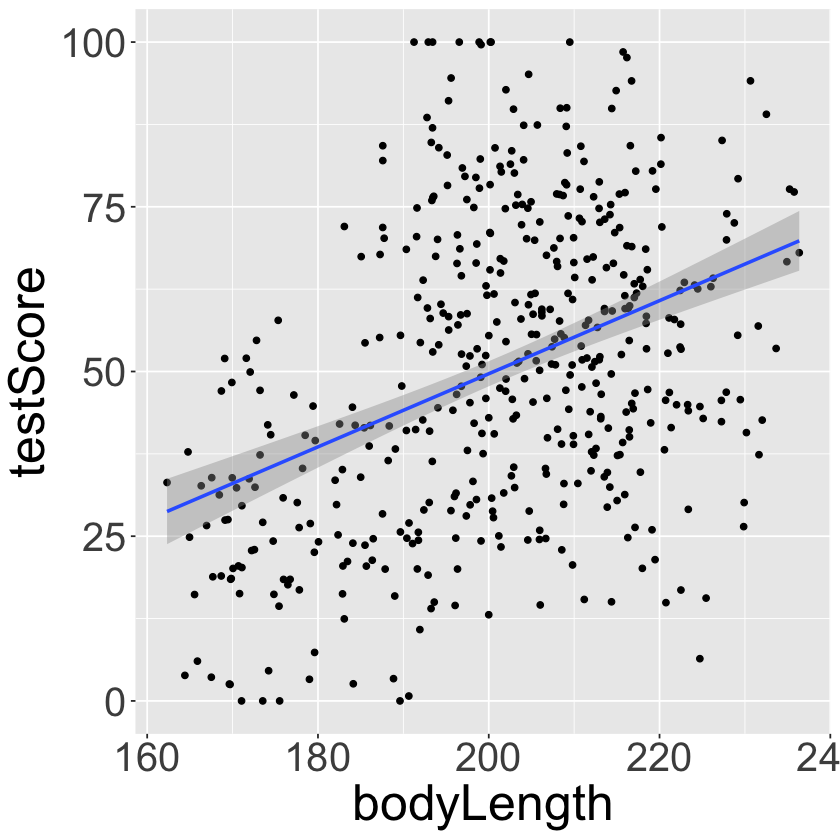

In [5]:
library(tidyverse)  # load the package containing both ggplot2 and dplyr

(prelim_plot <- ggplot(dragons, aes(x = bodyLength, y = testScore)) +
  geom_point() +
  geom_smooth(method = "lm") +
  theme(text = element_text(size = 30)))
# Note that putting your entire ggplot code in brackets () creates the graph and then shows it in the plot viewer

## Assumptions?

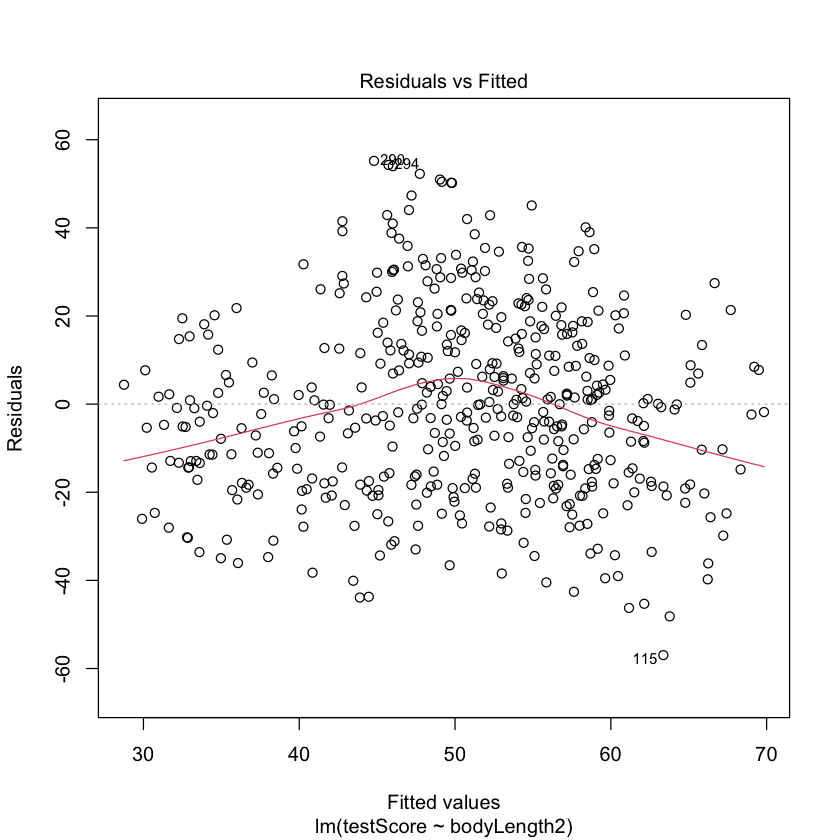

In [6]:
## Plot the residuals - the red line should be close to being flat, like the dashed grey line

plot(basic.lm, which = 1)  # not perfect, but look alright

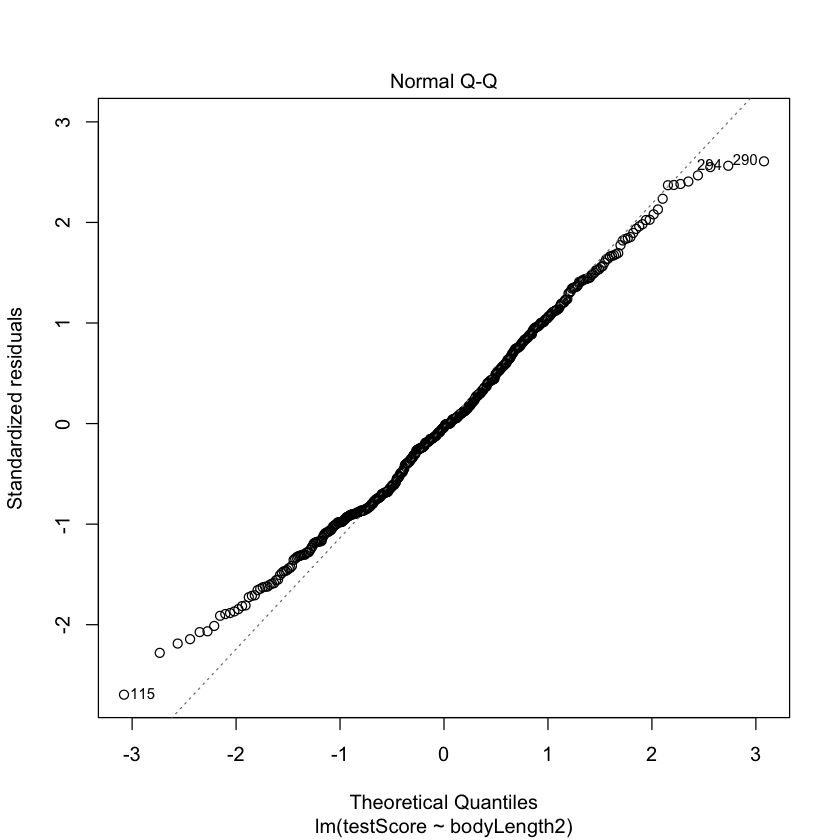

In [7]:
## Have a quick look at the  qqplot too - point should ideally fall onto the diagonal dashed line

plot(basic.lm, which = 2)  # a bit off at the extremes, but that's often the case; again doesn't look too bad

## However, what about observation independence? Are our data independent?
We collected multiple samples from eight mountain ranges. It's perfectly plausible that the data from within each mountain range are more similar to each other than the data from different mountain ranges - they are correlated. Pseudoreplication isn't our friend.

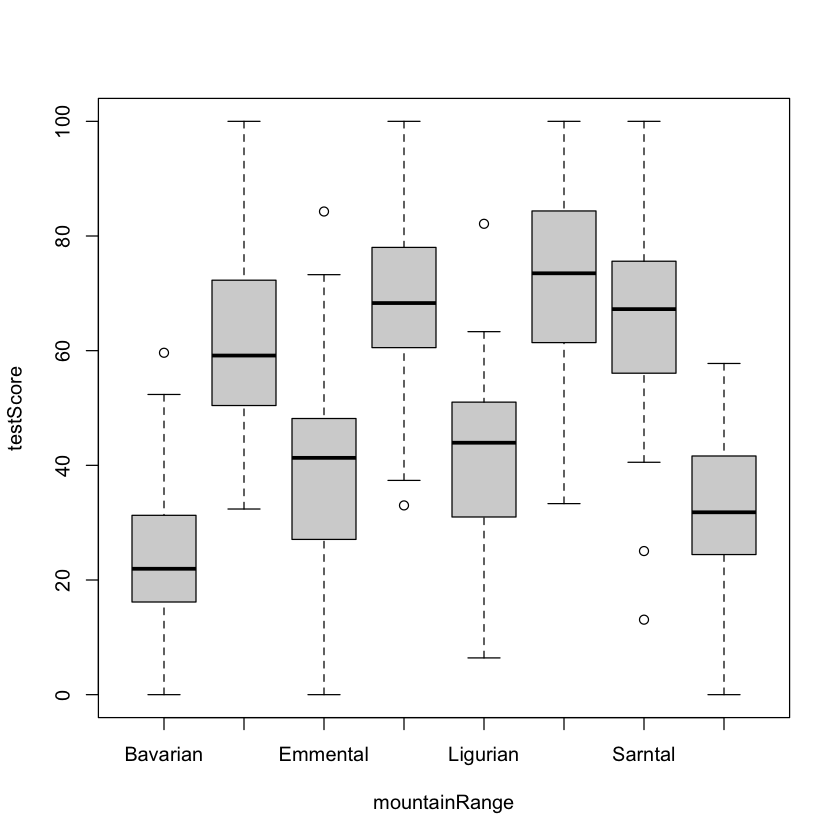

In [8]:
## Have a look at the data to see if above is true
boxplot(testScore ~ mountainRange, data = dragons)  # certainly looks like something is going on here

We could also plot it and colour points by mountain range

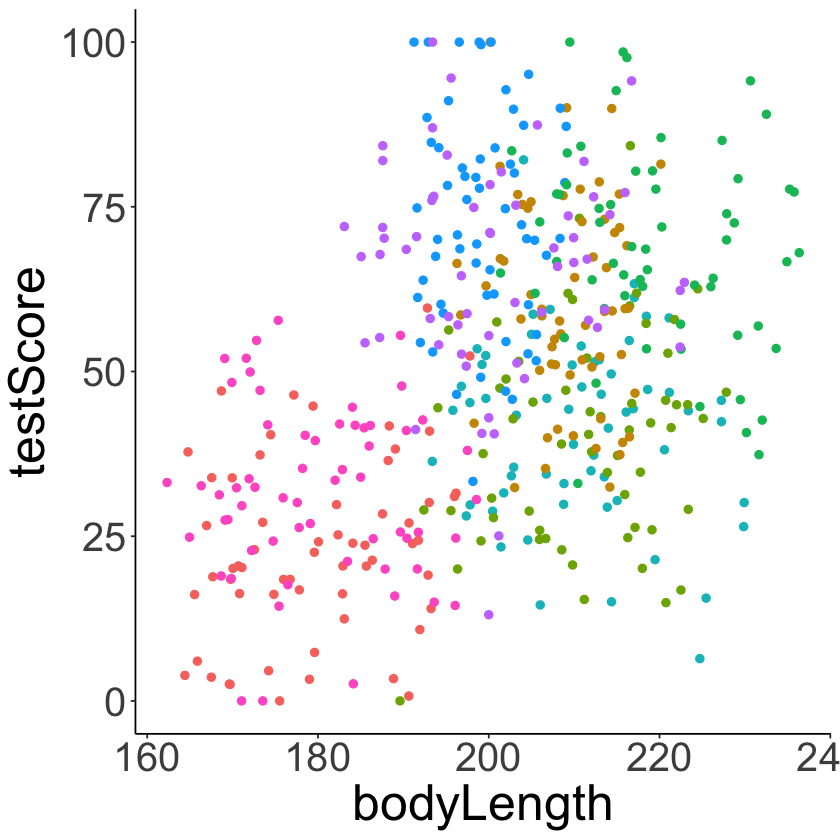

In [9]:
(colour_plot <- ggplot(dragons, aes(x = bodyLength, y = testScore, colour = mountainRange)) +
  geom_point(size = 2) +
  theme_classic() +
  theme(legend.position = "none", text = element_text(size = 30)))

From the above plots, it looks like our mountain ranges vary both in the dragon body length **AND** in their test scores. This confirms that our observations from within each of the ranges **aren’t independent**. We can’t ignore that: as we’re starting to see, it could lead to a completely erroneous conclusion.

So what do we do?

# 4. Run multiple analyses
We could run many separate analyses and fit a regression for each of the mountain ranges.
Lets have a quick look at the data split by mountain range. We use the ```facet_wrap``` to do that:

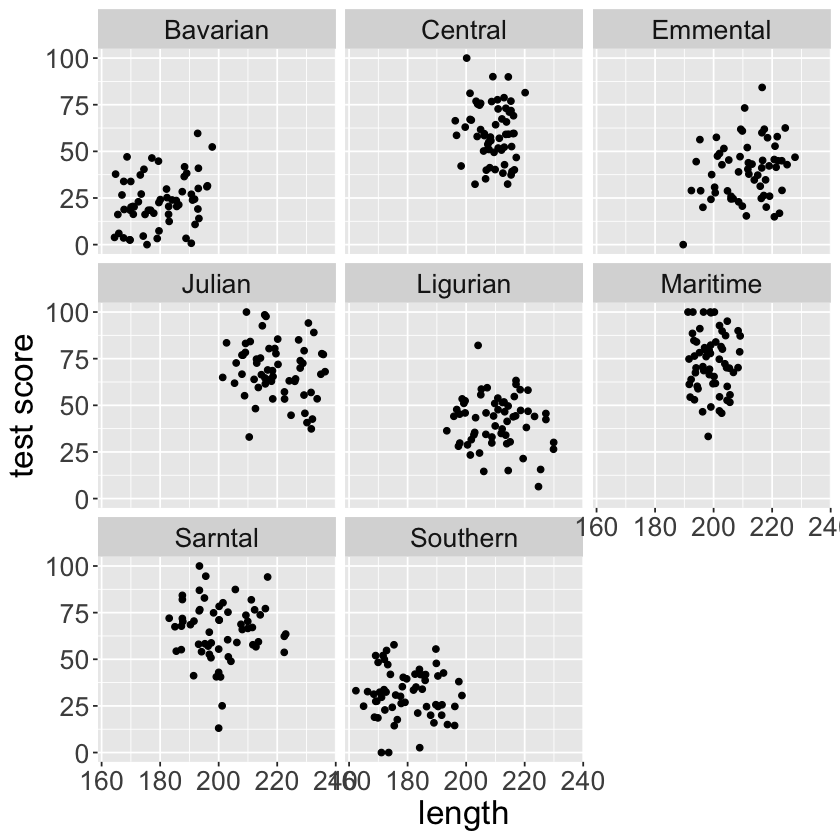

In [10]:
(split_plot <- ggplot(aes(bodyLength, testScore), data = dragons) + 
  geom_point() + 
  facet_wrap(~ mountainRange) + # create a facet for each mountain range
  xlab("length") + 
  ylab("test score") +
  theme(legend.position = "none", text = element_text(size = 20)))

That’s eight analyses. Oh wait, we also have different sites in each mountain range, which similarly to mountain ranges aren’t independent… So we could run an analysis for each site in each range separately.

To do the above, we would have to estimate a slope and intercept parameter for **each regression**. That’s two parameters, three sites and eight mountain ranges, which means **48 parameter estimates** (2 x 3 x 8 = 48)! Moreover, the sample size for each analysis would be only 20 (dragons per site).

This presents problems: not only are we **hugely decreasing our sample size**, but we are also **increasing chances of a Type I Error (where you falsely reject the null hypothesis) by carrying out multiple comparisons**. Not ideal!

# 5. Modify the current model

We want to use all the data, but account for the data coming from different mountain ranges (let’s put sites on hold for a second to make things simpler).

Add mountain range as a fixed effect to our ```basic.lm```

In [11]:
mountain.lm <- lm(testScore ~ bodyLength2 + mountainRange, data = dragons)
summary(mountain.lm)


Call:
lm(formula = testScore ~ bodyLength2 + mountainRange, data = dragons)

Residuals:
    Min      1Q  Median      3Q     Max 
-52.263  -9.926   0.361   9.994  44.488 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            23.3818     2.5792   9.065  < 2e-16 ***
bodyLength2             0.2055     1.2927   0.159  0.87379    
mountainRangeCentral   36.5828     3.5993  10.164  < 2e-16 ***
mountainRangeEmmental  16.2092     3.6966   4.385 1.43e-05 ***
mountainRangeJulian    45.1147     4.1901  10.767  < 2e-16 ***
mountainRangeLigurian  17.7478     3.6736   4.831 1.84e-06 ***
mountainRangeMaritime  49.8813     3.1392  15.890  < 2e-16 ***
mountainRangeSarntal   41.9784     3.1972  13.130  < 2e-16 ***
mountainRangeSouthern   8.5196     2.7313   3.119  0.00192 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14.96 on 471 degrees of freedom
Multiple R-squared:  0.5843,	Adjusted R-squared:  0.5773 
F

Now body length is *not significant*. But let’s think about what we are doing here for a second. The above model is estimating the difference in test scores between the mountain ranges - we can see all of them in the model output returned by `summary()`. But we are not interested in quantifying test scores for each specific mountain range: we just want to know whether body length affects test scores and we want to **simply control for the variation coming from mountain ranges**.

This is what we refer to as **“random factors”** and so we arrive at mixed effects models. Ta-daa!

# 6. Mixed effects models

A mixed model is a good choice here: it will allow us to **use all the data we have** (larger sample size) and **account for the correlations between data** coming from the sites and mountain ranges. We will also **estimate fewer parameters and avoid problems with multiple comparisons** that we would encounter while using separate regressions.

We are going to work in `lme4`, so load the package (or use `install.packages` if you don’t have `lme4` on your computer).

In [12]:
library(lme4)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




## First mixed model

We have a response variable, the test score and we are attempting to explain part of the variation in test score through fitting body length as a fixed effect. But the response variable has some residual variation (i.e. unexplained variation) associated with mountain ranges. By using random effects, we are modeling that unexplained variation through variance.

Note that our question changes slightly here: while we still want to know whether there is an association between dragon’s body length and the test score, we want to know if that association exists **after controlling for the variation in mountain ranges**.

We will fit the random effect using the syntax `(1|variableName)`. Whatever is on the right side of the `|` operator is a factor and referred to as a “grouping factor” for the term.

In [13]:
mixed.lmer <- lmer(testScore ~ bodyLength2 + (1|mountainRange), data = dragons)
summary(mixed.lmer)

Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (1 | mountainRange)
   Data: dragons

REML criterion at convergence: 3985.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4815 -0.6513  0.0066  0.6685  2.9583 

Random effects:
 Groups        Name        Variance Std.Dev.
 mountainRange (Intercept) 339.7    18.43   
 Residual                  223.8    14.96   
Number of obs: 480, groups:  mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)  50.3860     6.5517   7.690
bodyLength2   0.5377     1.2750   0.422

Correlation of Fixed Effects:
            (Intr)
bodyLength2 0.000 

The **random effect part** tells you how much variance you find among levels of your grouping factor(s), plus the residual variance.

The **fixed effect part** is very similar to a linear model output.

Once we account for the mountain ranges, it’s obvious that dragon body length doesn’t actually explain the differences in the test scores.

Take a look at the summary output: notice how the model estimate is smaller than its associated error? That means that the effect, or slope, cannot be distinguised from zero.

Keep in mind that the random effect of the mountain range is **meant to capture all the influences of mountain ranges on dragon test scores** - whether we observed those influences explicitly or not, whether those influences are big or small etc. It could be many, many teeny-tiny influences that, when combined, affect the test scores and that’s what we are hoping to control for.

We can see the variance for `mountainRange = 339.7`. Mountain ranges are clearly important: they explain a lot of variation. How do we know that? We can take the variance for the mountainRange and divide it by the total variance:

In [14]:
cat("mountain ranges explain", 339.7/(339.7 + 223.8)*100, "% of the variance that's left over after the variance expained by our fixed effects.")

mountain ranges explain 60.28394 % of the variance that's left over after the variance expained by our fixed effects.

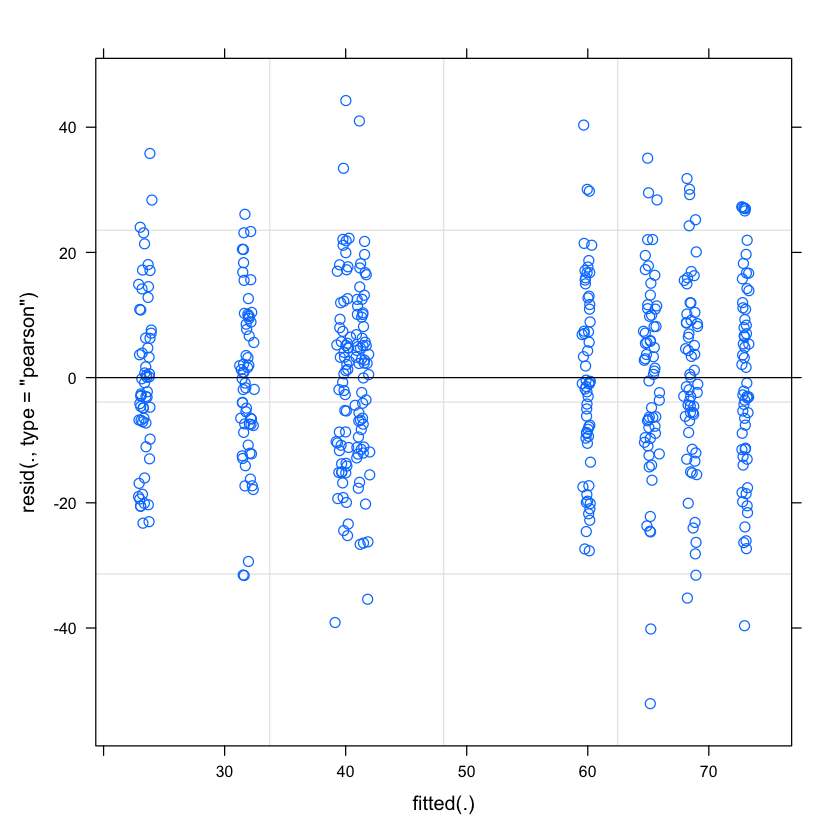

In [15]:
# As always, it’s good practice to have a look at the plots to check our assumptions:
plot(mixed.lmer)  # looks alright, no patterns evident

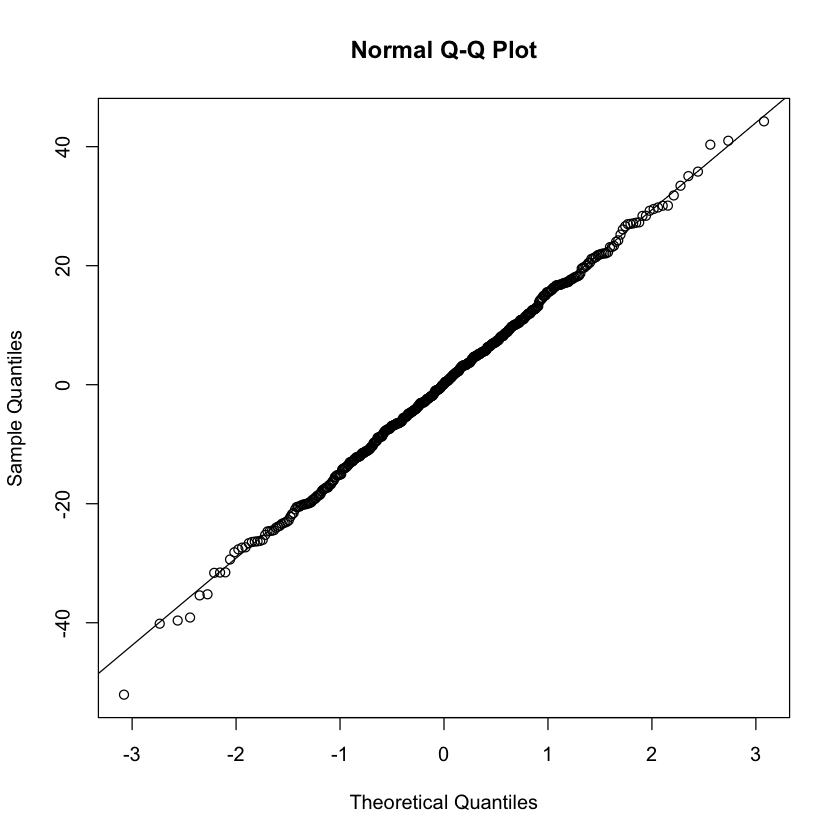

In [16]:
qqnorm(resid(mixed.lmer))
qqline(resid(mixed.lmer))  # points fall nicely onto the line - good!

## Types of random effects

Random effects (factors) can be **crossed** or **nested** - it depends on the relationship between the variables.

**Nesting is a property of the data, or rather the experimental design, not the model.**

The difference between crossed and nested random effects is that nested random effects occur when **one factor (grouping variable) appears only within a particular level of another factor (grouping variable)**. This is specified in `lme4` with:

`(1|group1/group2)` or `(1|group1) + (1|group1:group2)`

where `group2` is nested within `group1`.

Crossed random effects are simply: not nested. This can occur with three or more grouping variables (factors) where one factor is separately nested in both of the others, or with two or more factors where individual observations are nested separately within the two factors. These are specified in `lme4` with:

`(1|group1) + (1|group2)`

*[cited from Robert Long (https://stats.stackexchange.com/users/7486/robert-long), Crossed vs nested random effects: how do they differ and how are they specified correctly in lme4?, URL (version: 2020-10-06): https://stats.stackexchange.com/q/228814*]

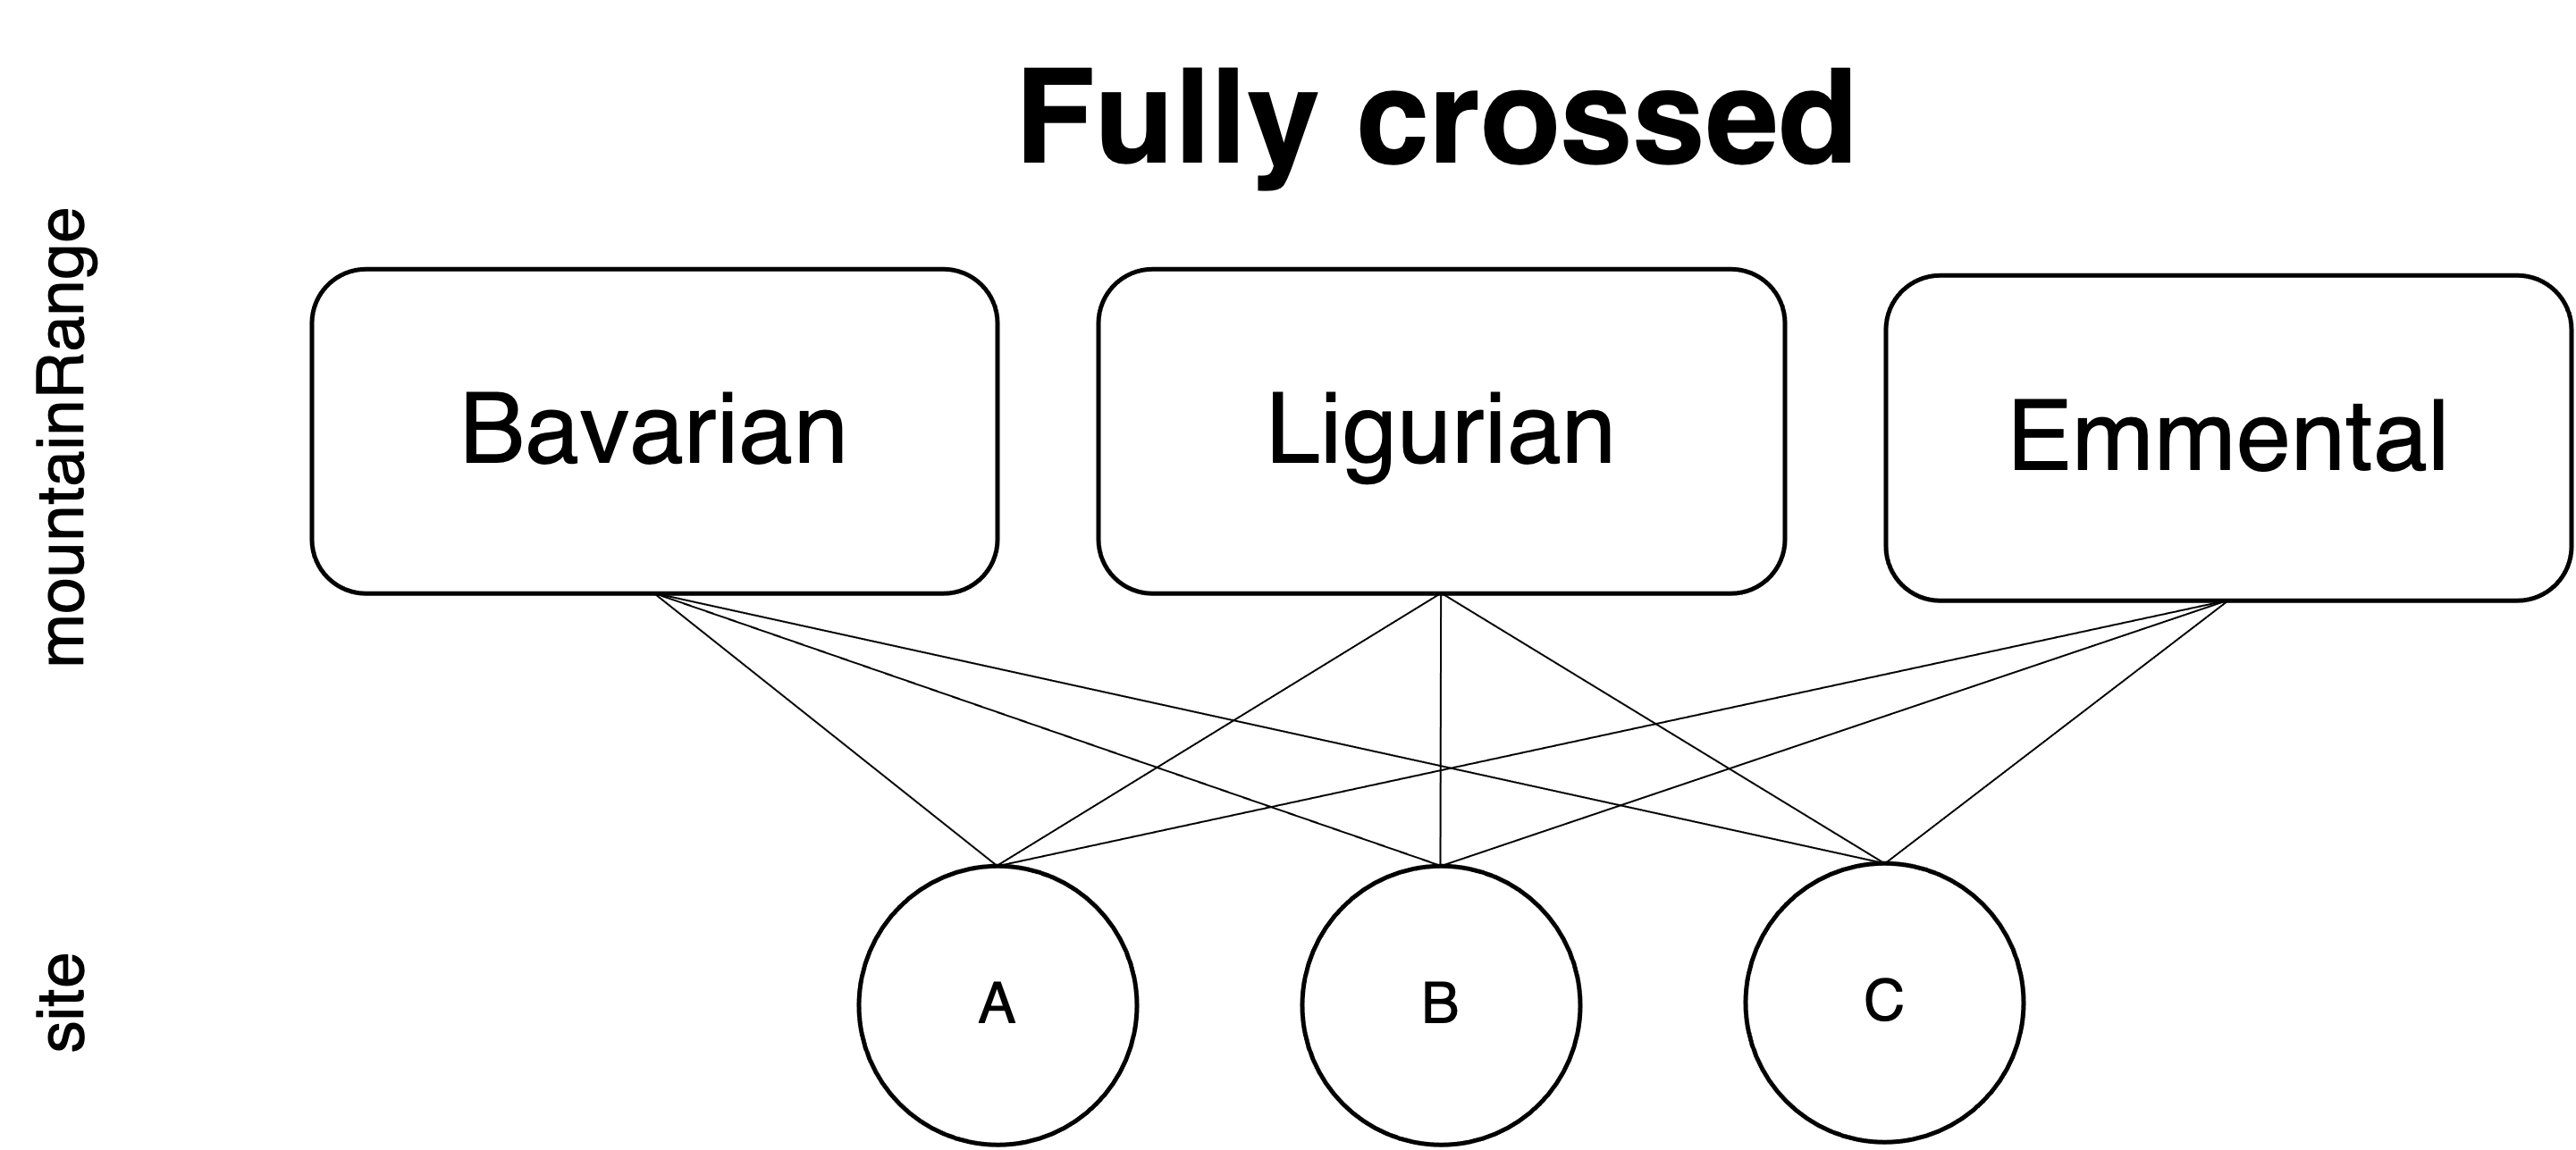

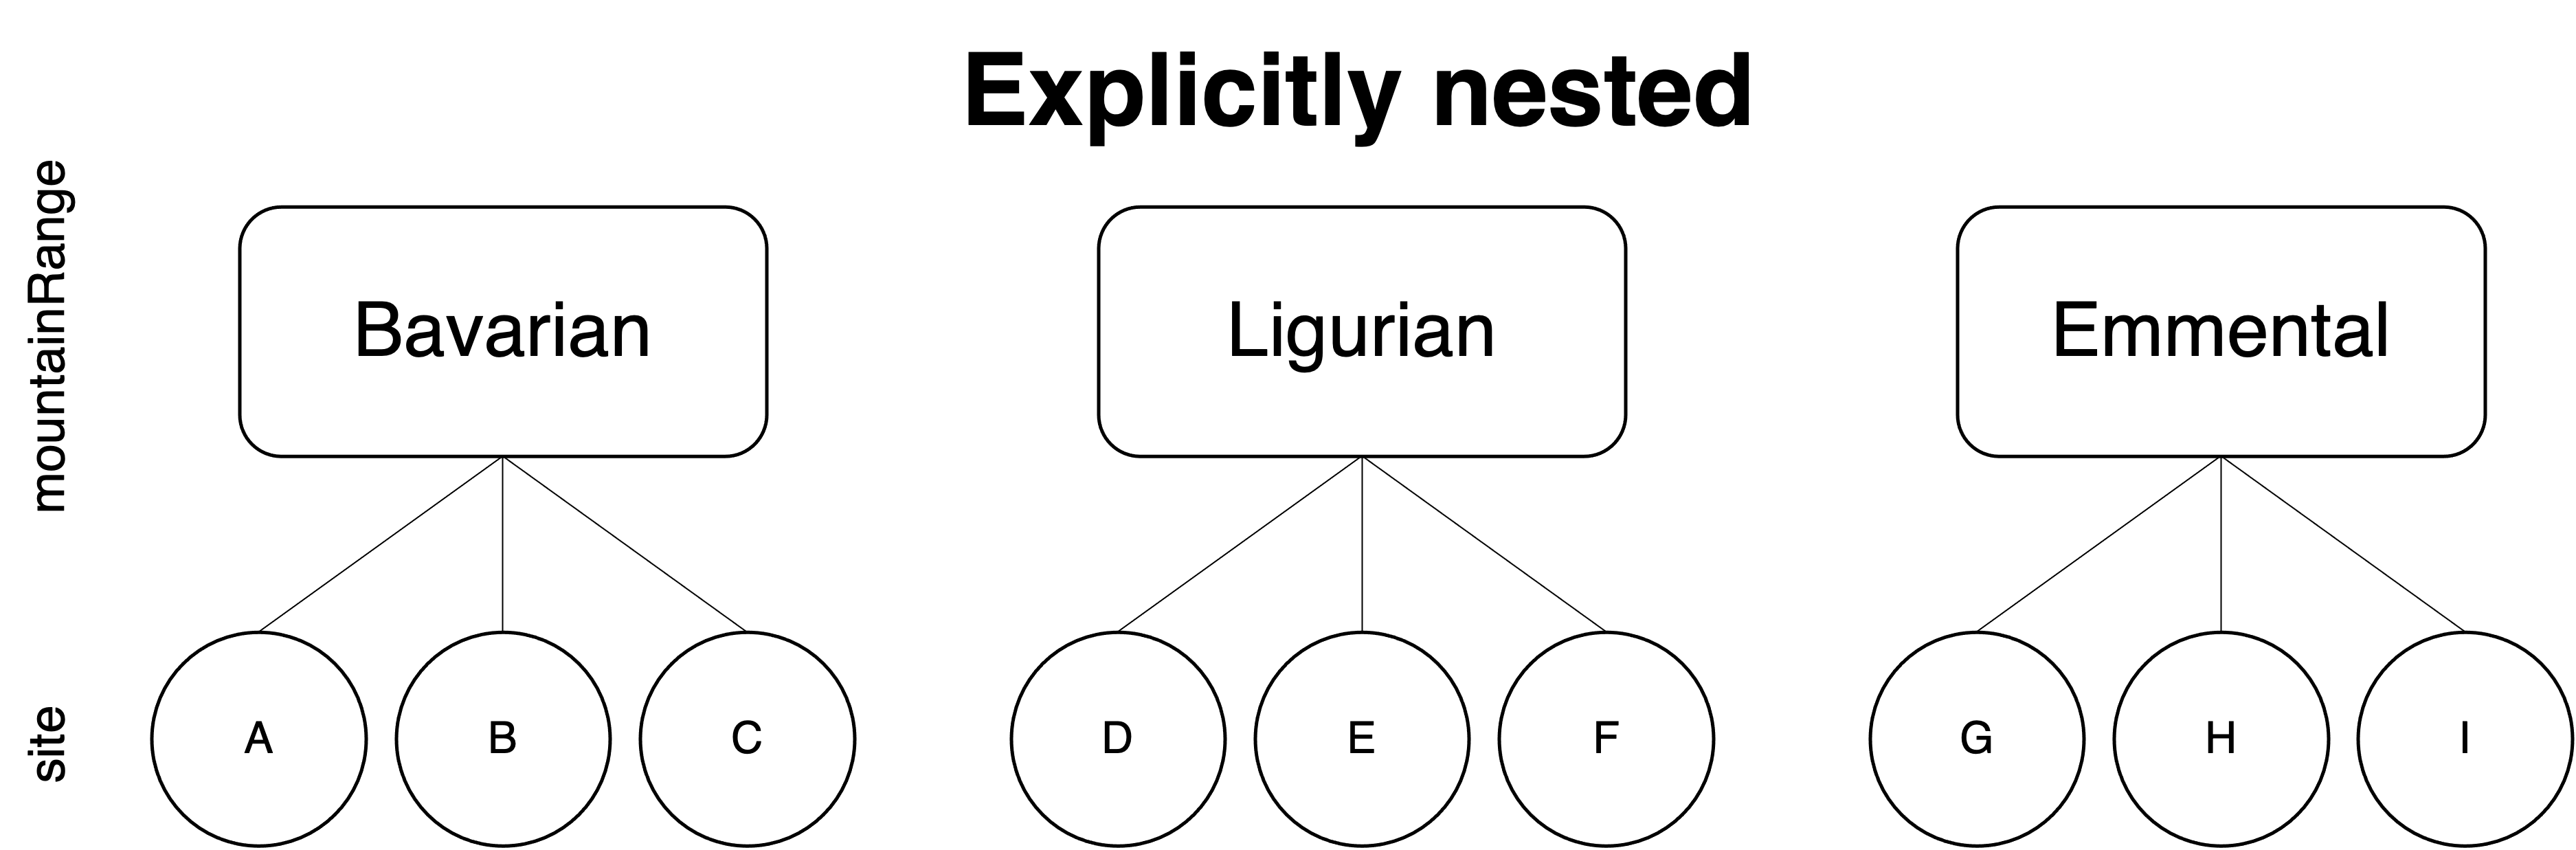

However, in this example, even all three sites `a`, `b`, and `c` are under each level of `mountainRange` and thus appeared to be fully crossed, they were actually different sites. It is called **implicit nesting**, and should be recoded as **explicit nesting**.

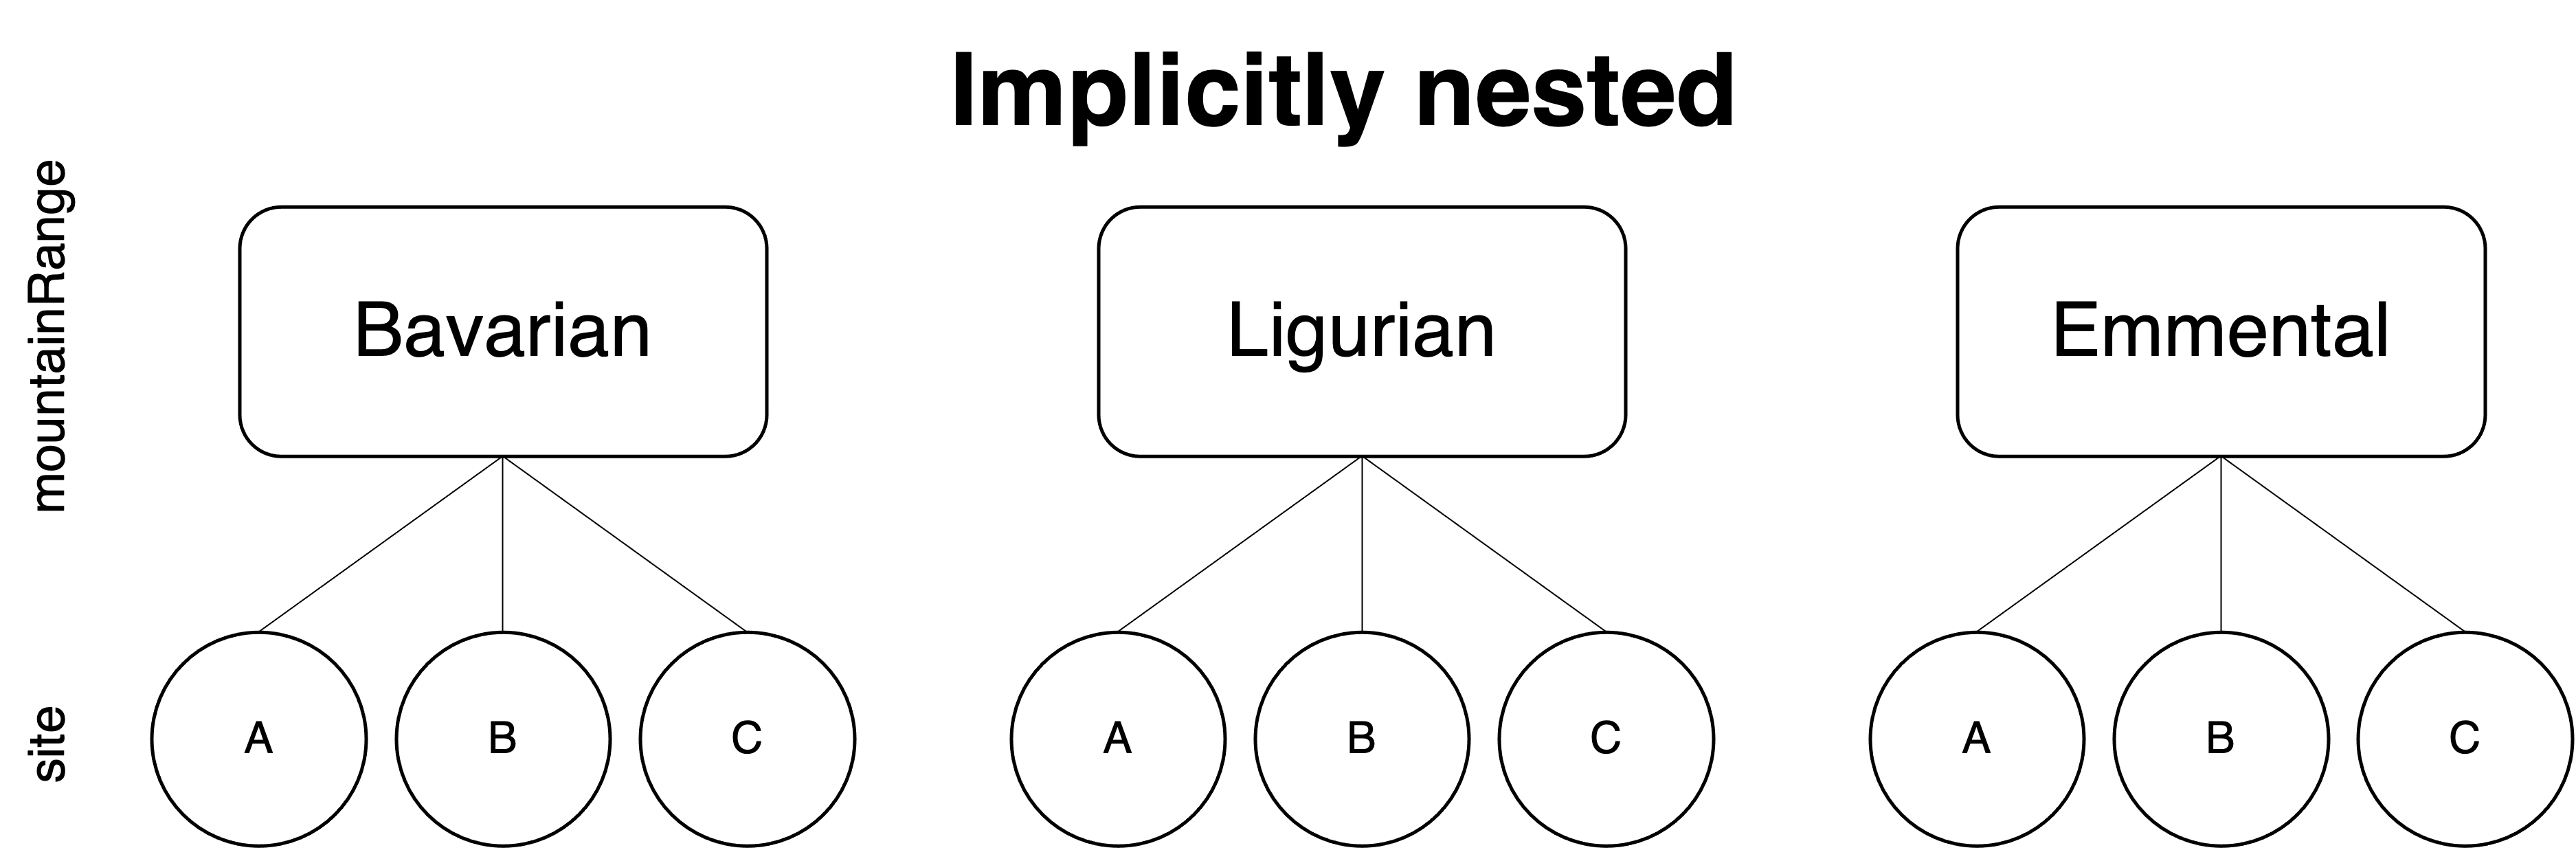

In [17]:
dragons <- within(dragons, sample <- factor(mountainRange:site))
head(dragons)

,testScore,bodyLength,mountainRange,X,site,bodyLength2,sample
,<dbl>,<dbl>,<fct>,<lgl>,<fct>,"<dbl[,1]>",<fct>
1,16.147309,165.5485,Bavarian,NA,a,-2.206233,Bavarian:a
2,33.886183,167.5593,Bavarian,NA,a,-2.082204,Bavarian:a
3,6.038333,165.8830,Bavarian,NA,a,-2.185605,Bavarian:a
4,18.838821,167.6855,Bavarian,NA,a,-2.074419,Bavarian:a
5,33.862328,169.9597,Bavarian,NA,a,-1.934145,Bavarian:a
6,47.043246,168.6887,Bavarian,NA,a,-2.012538,Bavarian:a


In [18]:
# the wrong model
mixed.WRONG <- lmer(testScore ~ bodyLength2 + (1|mountainRange) + (1|site), data = dragons)  # treats the two random effects as if they are crossed
summary(mixed.WRONG)
# The sites should be 8*3 = 24, but appeared 3 as it was not recoded.

Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (1 | mountainRange) + (1 | site)
   Data: dragons

REML criterion at convergence: 3980.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5079 -0.6489  0.0138  0.6976  3.0851 

Random effects:
 Groups        Name        Variance Std.Dev.
 mountainRange (Intercept) 409.90   20.246  
 site          (Intercept)  10.52    3.243  
 Residual                  219.19   14.805  
Number of obs: 480, groups:  mountainRange, 8; site, 3

Fixed effects:
            Estimate Std. Error t value
(Intercept)   50.386      7.430   6.782
bodyLength2   -2.600      1.641  -1.584

Correlation of Fixed Effects:
            (Intr)
bodyLength2 0.000 

In [19]:
# the correct model, version 1
mixed.lmer1 <- lmer(testScore ~ bodyLength2 + (1|mountainRange) + (1|sample), data = dragons)  # the syntax stays the same, but now the nesting is taken into account
summary(mixed.lmer1)

Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (1 | mountainRange) + (1 | sample)
   Data: dragons

REML criterion at convergence: 3970.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2425 -0.6752 -0.0117  0.6974  2.8812 

Random effects:
 Groups        Name        Variance Std.Dev.
 sample        (Intercept)  23.09    4.805  
 mountainRange (Intercept) 327.56   18.099  
 Residual                  208.58   14.442  
Number of obs: 480, groups:  sample, 24; mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)   50.386      6.507   7.743
bodyLength2    0.831      1.681   0.494

Correlation of Fixed Effects:
            (Intr)
bodyLength2 0.000 

Here, we are trying to account for all the mountain-range-level and all the site-level influences and we are hoping that our random effects have soaked up all these influences so we can control for them in the model.

In [20]:
# the correct model, version 2
mixed.lmer2 <- lmer(testScore ~ bodyLength2 + (1|mountainRange/site), data = dragons)  # the syntax stays the same, but now the nesting is taken into account
summary(mixed.lmer2)

Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (1 | mountainRange/site)
   Data: dragons

REML criterion at convergence: 3970.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2425 -0.6752 -0.0117  0.6974  2.8812 

Random effects:
 Groups             Name        Variance Std.Dev.
 site:mountainRange (Intercept)  23.09    4.805  
 mountainRange      (Intercept) 327.56   18.099  
 Residual                       208.58   14.442  
Number of obs: 480, groups:  site:mountainRange, 24; mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)   50.386      6.507   7.743
bodyLength2    0.831      1.681   0.494

Correlation of Fixed Effects:
            (Intr)
bodyLength2 0.000 

In [21]:
# the correct model, version 3
mixed.lmer3 <- lmer(testScore ~ bodyLength2 + (1|mountainRange) + (1|mountainRange:site), data = dragons)  # the syntax stays the same, but now the nesting is taken into account
summary(mixed.lmer3)

Linear mixed model fit by REML ['lmerMod']
Formula: 
testScore ~ bodyLength2 + (1 | mountainRange) + (1 | mountainRange:site)
   Data: dragons

REML criterion at convergence: 3970.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2425 -0.6752 -0.0117  0.6974  2.8812 

Random effects:
 Groups             Name        Variance Std.Dev.
 mountainRange:site (Intercept)  23.09    4.805  
 mountainRange      (Intercept) 327.56   18.099  
 Residual                       208.58   14.442  
Number of obs: 480, groups:  mountainRange:site, 24; mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)   50.386      6.507   7.743
bodyLength2    0.831      1.681   0.494

Correlation of Fixed Effects:
            (Intr)
bodyLength2 0.000 

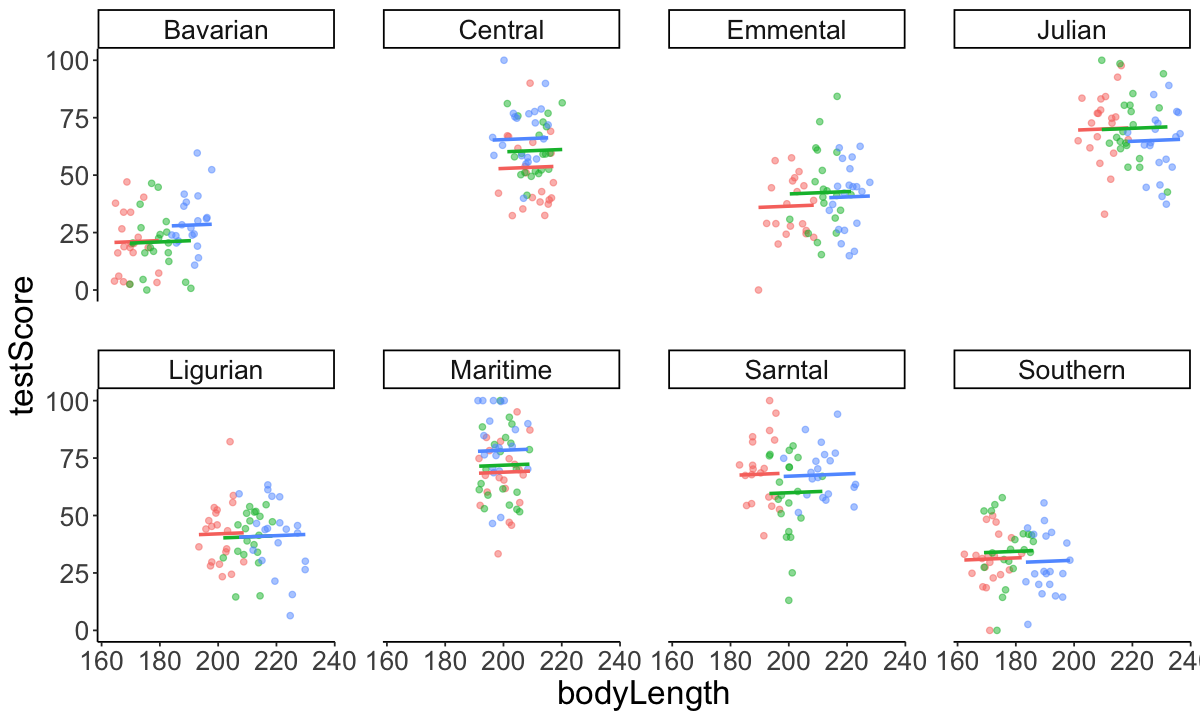

In [22]:
options(repr.plot.width=10, repr.plot.height=6)
(mm_plot <- ggplot(dragons, aes(x = bodyLength, y = testScore, colour = site)) +
      facet_wrap(~mountainRange, nrow=2) +   # a panel for each mountain range
      geom_point(alpha = 0.5) +
      theme_classic() +
      geom_line(data = cbind(dragons, pred = predict(mixed.lmer1)), aes(y = pred), linewidth = 1) +  # adding predicted line from mixed model 
      theme(legend.position = "none",
            panel.spacing = unit(2, "lines"), text = element_text(size = 20))  # adding space between panels
)

## Random Slope

A random-intercept model allows the intercept to vary for each level of the random effects, but keeps the slope constant among them. So in our case, using this model means that we expect dragons in all mountain ranges to exhibit the same relationship between body length and intelligence (fixed slope), although we acknowledge that some populations may be smarter or dumber to begin with (random intercept).

Now, in the life sciences, we perhaps more often assume that not all populations would show the exact same relationship, for instance if your study sites/populations are very far apart and have some relatively important environmental, genetic, etc differences. Therefore, we often want to fit a random-slope and random-intercept model. Maybe the dragons in a very cold vs a very warm mountain range have evolved different body forms for heat conservation and may therefore be smart even if they’re smaller than average.

### Random slope without randon intercept (very uncommon)
Don't use it unless you have a good reason.

In [23]:
# only random slope, no random intercept
mixed.ran_slopeOnly <- lmer(testScore ~ bodyLength2 + (0+bodyLength2|mountainRange/site), data = dragons) 

summary(mixed.ran_slopeOnly)

Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (0 + bodyLength2 | mountainRange/site)
   Data: dragons

REML criterion at convergence: 4134.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.02051 -0.61093 -0.01695  0.67518  2.66382 

Random effects:
 Groups             Name        Variance Std.Dev.
 site:mountainRange bodyLength2 146.4    12.10   
 mountainRange      bodyLength2 199.8    14.13   
 Residual                       292.0    17.09   
Number of obs: 480, groups:  site:mountainRange, 24; mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)   56.982      1.288  44.254
bodyLength2    3.374      5.750   0.587

Correlation of Fixed Effects:
            (Intr)
bodyLength2 -0.022

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


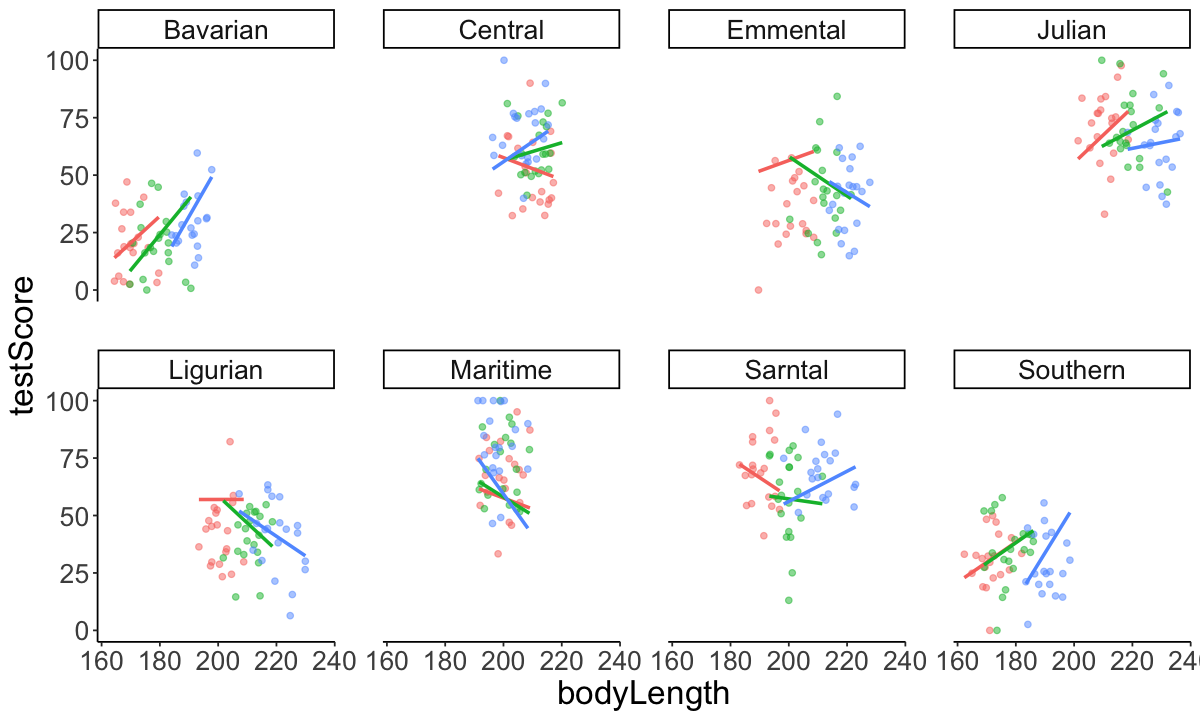

In [24]:
### plot
options(repr.plot.width=10, repr.plot.height=6)
(mm_plot <- ggplot(dragons, aes(x = bodyLength, y = testScore, colour = site)) +
      facet_wrap(~mountainRange, nrow=2) +   # a panel for each mountain range
      geom_point(alpha = 0.5) +
      theme_classic() +
      geom_line(data = cbind(dragons, pred = predict(mixed.ran_slopeOnly)), aes(y = pred), size = 1) +  # adding predicted line from mixed model 
      theme(legend.position = "none",
            panel.spacing = unit(2, "lines"), text = element_text(size = 20))  # adding space between panels
)

### Full model: Random intercept + Random slope (common)

In [25]:
mixed.ran_full <- lmer(testScore ~ bodyLength2 + (1+bodyLength2|mountainRange/site), data = dragons) 

summary(mixed.ran_full)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (1 + bodyLength2 | mountainRange/site)
   Data: dragons

REML criterion at convergence: 3968.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2654 -0.6737 -0.0200  0.6931  2.8432 

Random effects:
 Groups             Name        Variance Std.Dev. Corr 
 site:mountainRange (Intercept)  19.8156  4.4515       
                    bodyLength2   0.7178  0.8472  1.00 
 mountainRange      (Intercept) 310.9691 17.6343       
                    bodyLength2   6.1119  2.4722  -1.00
 Residual                       208.5025 14.4396       
Number of obs: 480, groups:  site:mountainRange, 24; mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)  51.4263     6.3408   8.110
bodyLength2   0.6691     1.8729   0.357

Correlation of Fixed Effects:
            (Intr)
bodyLength2 -0.461
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')


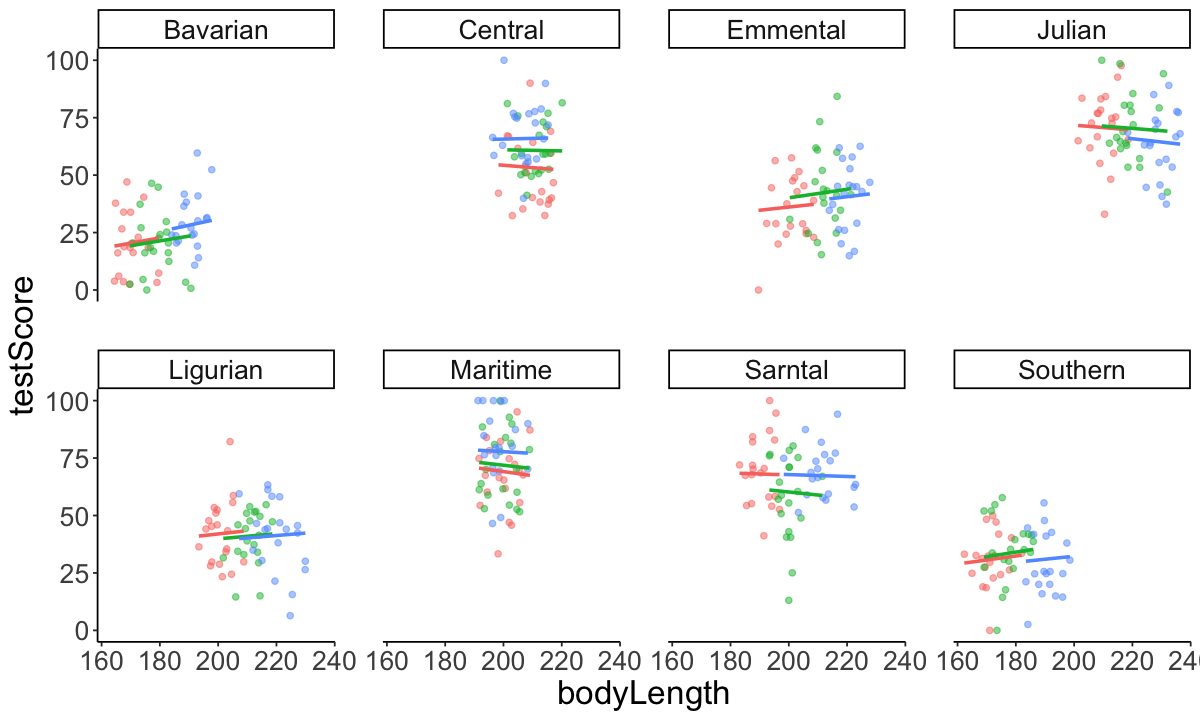

In [26]:
### plot
options(repr.plot.width=10, repr.plot.height=6)
(mm_plot <- ggplot(dragons, aes(x = bodyLength, y = testScore, colour = site)) +
      facet_wrap(~mountainRange, nrow=2) +   # a panel for each mountain range
      geom_point(alpha = 0.5) +
      theme_classic() +
      geom_line(data = cbind(dragons, pred = predict(mixed.ran_full)), aes(y = pred), size = 1) +  # adding predicted line from mixed model 
      theme(legend.position = "none",
            panel.spacing = unit(2, "lines"), text = element_text(size = 20))  # adding space between panels
)

# 7. Visualization

Often you will want to visualise your model as a regression line with some error around it, just like you would a simple linear model. However, `ggplot2` stats options are not designed to estimate mixed-effect model objects correctly, so we will use the `ggeffects` package to help us draw the plots.

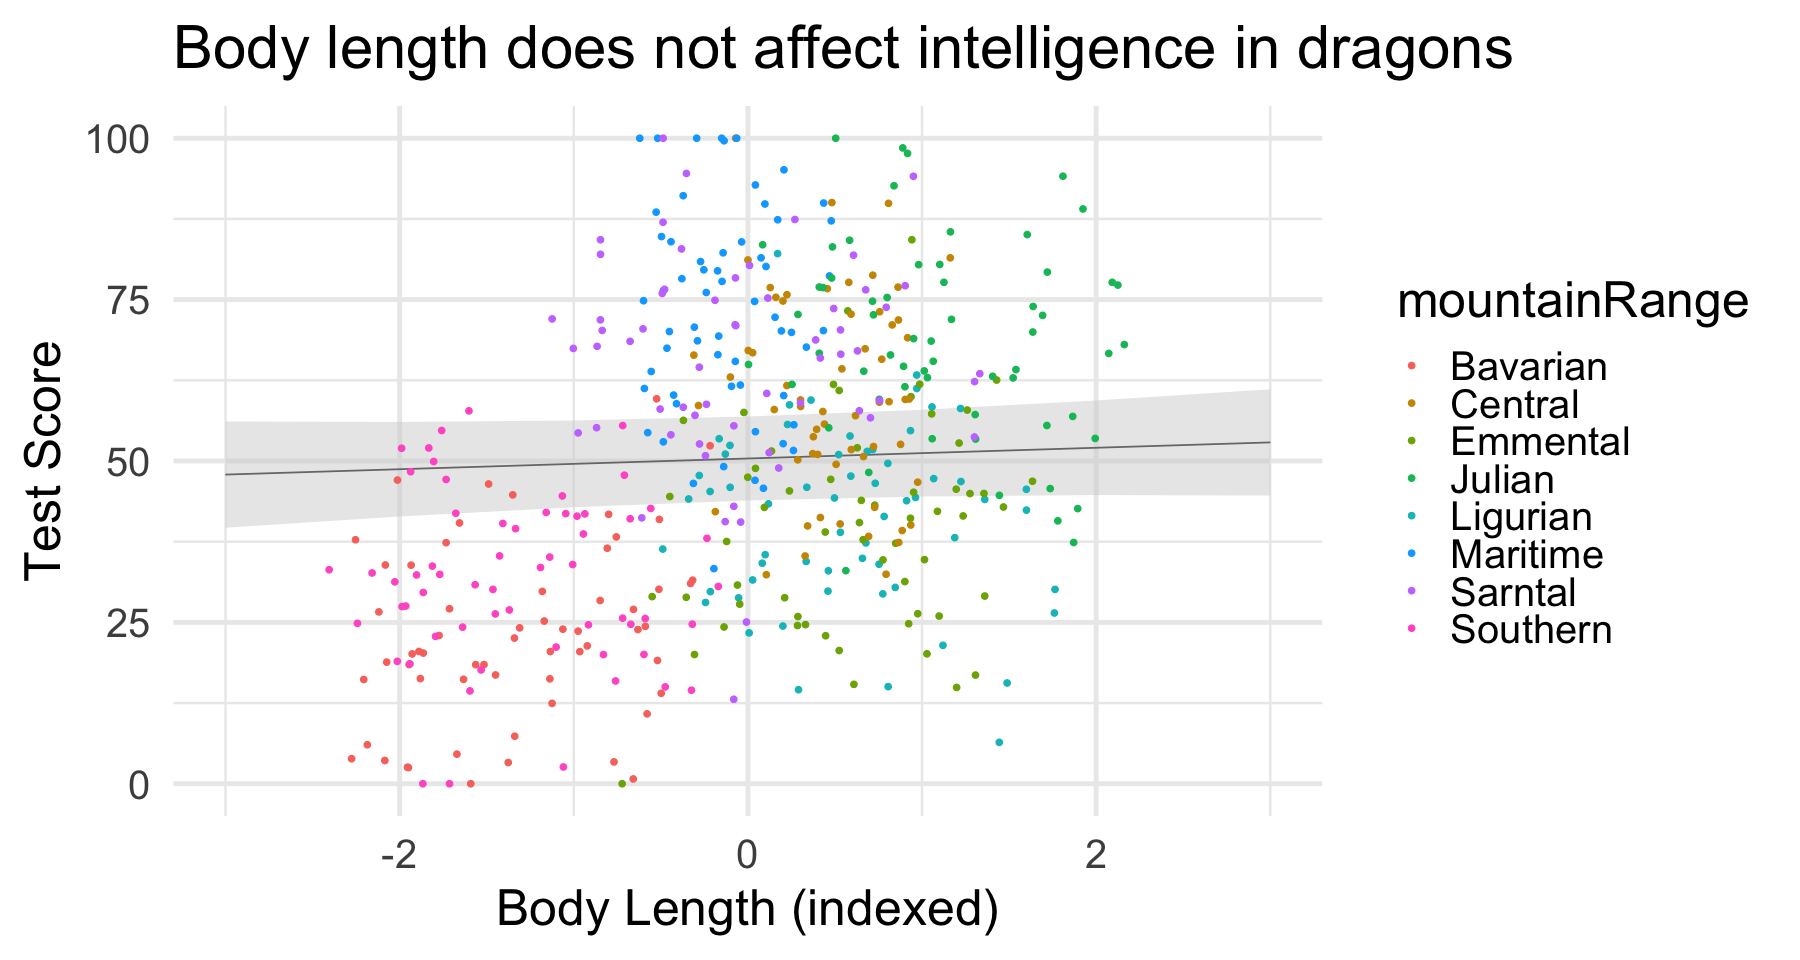

In [27]:
library(ggeffects)  # install the package first if you haven't already, then load it

options(repr.plot.width=15, repr.plot.height=8)
# Extract the prediction data frame
pred.mm <- ggpredict(mixed.lmer2, terms = c("bodyLength2"))  # this gives overall predictions for the model

# Plot the predictions 
(ggplot(pred.mm) + 
   geom_line(aes(x = x, y = predicted)) +          # slope
   geom_ribbon(aes(x = x, ymin = predicted - std.error, ymax = predicted + std.error), 
               fill = "lightgrey", alpha = 0.5) +  # error band
   geom_point(data = dragons,                      # adding the raw data (scaled values)
              aes(x = bodyLength2, y = testScore, colour = mountainRange)) + 
   labs(x = "Body Length (indexed)", y = "Test Score", 
        title = "Body length does not affect intelligence in dragons") + 
   theme_minimal(base_size = 30)
)

What if you want to visualise how the relationships vary according to different levels of random effects? You can specify `type = "re"` (for “random effects”) in the `ggpredict()` function, and add the random effect name to the terms argument.

We also demonstrate a way to plot the graph quicker with the `plot()` function of `ggEffects`:

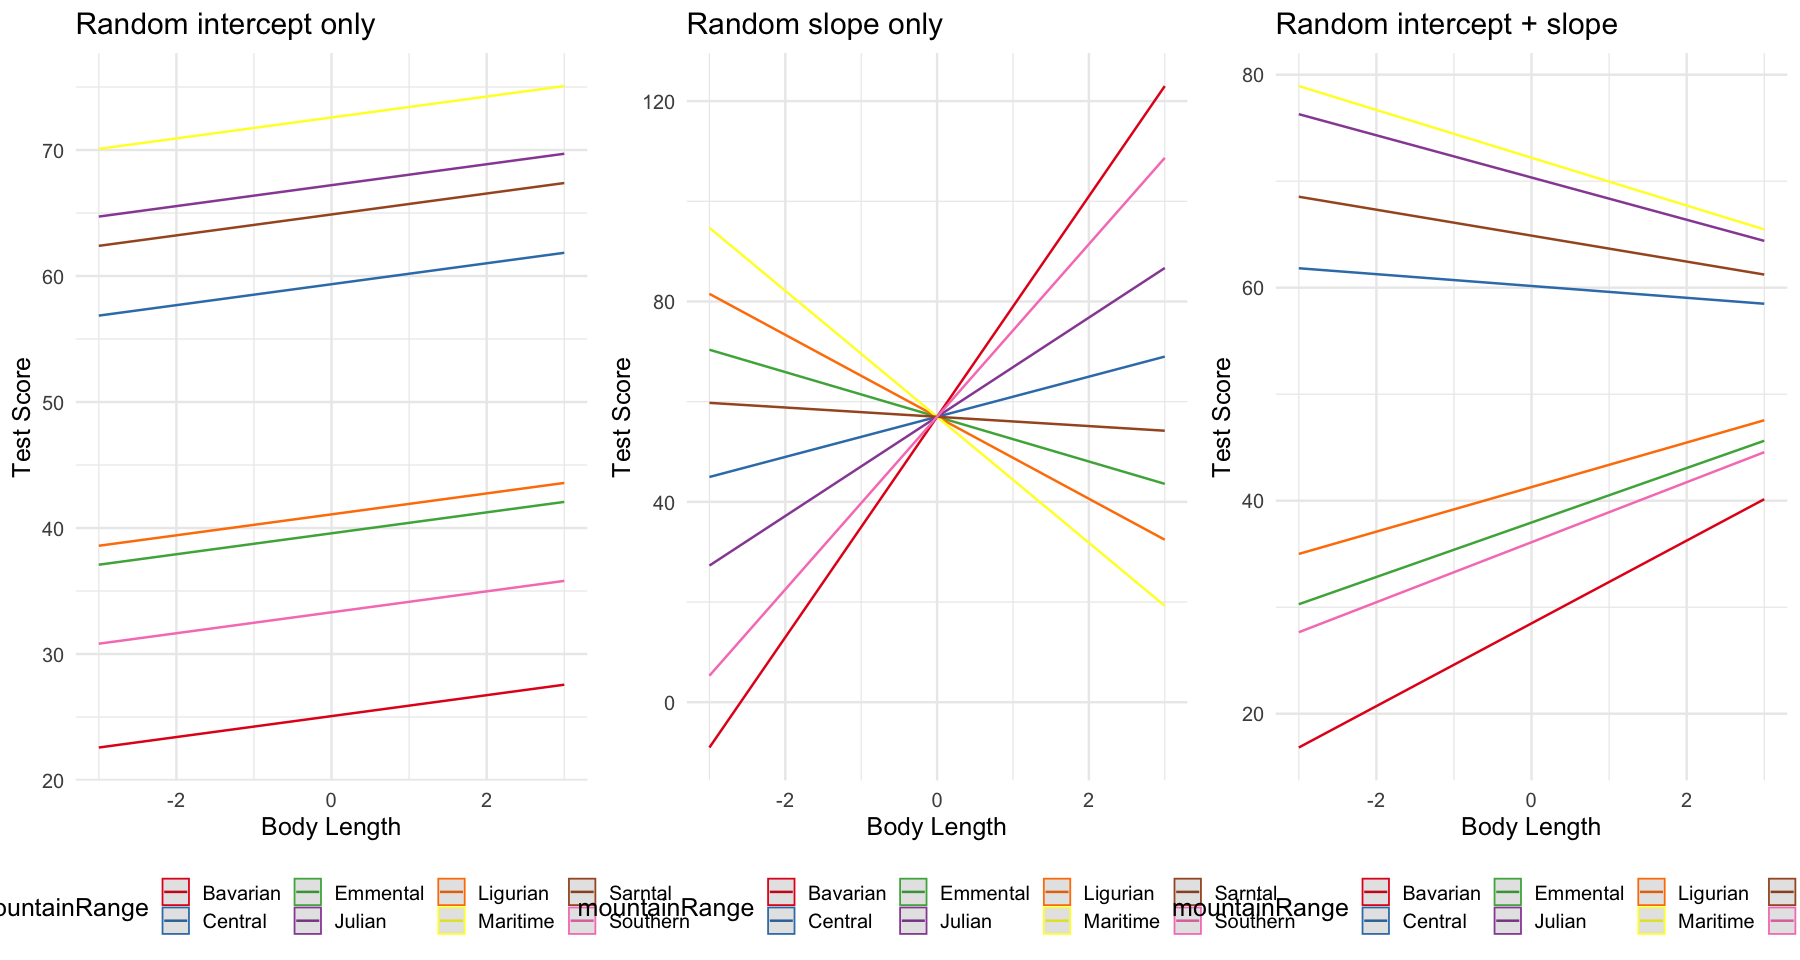

In [28]:
library(ggpubr)

options(repr.plot.width=15, repr.plot.height=8)

p1 = ggpredict(mixed.lmer2, terms = c("bodyLength2", "mountainRange"), type = "re", ci.lvl = FALSE) %>% 
   plot() +
   labs(x = "Body Length", y = "Test Score", title = "Random intercept only") + 
   theme_minimal(base_size = 15) +
   theme(legend.position="bottom")

p2 = ggpredict(mixed.ran_slopeOnly, terms = c("bodyLength2", "mountainRange"), type = "re", ci.lvl = FALSE) %>% 
   plot() +
   labs(x = "Body Length", y = "Test Score", title = "Random slope only") + 
   theme_minimal(base_size = 15) +
   theme(legend.position="bottom")

p3 = ggpredict(mixed.ran_full, terms = c("bodyLength2", "mountainRange"), type = "re", ci.lvl = FALSE) %>% 
   plot() +
   labs(x = "Body Length", y = "Test Score", title = "Random intercept + slope") + 
   theme_minimal(base_size = 15) +
   theme(legend.position="bottom")

figure <- ggarrange(p1, p2, p3,
                    ncol = 3, nrow = 1)
figure

# if you want confidence bands, change it into ci.lvl = 0.95

Learn more about sjPlot with 'browseVignettes("sjPlot")'.

Warning message in checkMatrixPackageVersion():
“Package version inconsistency detected.
TMB was built with Matrix version 1.5.1
Current Matrix version is 1.5.3
Please re-install 'TMB' from source using install.packages('TMB', type = 'source') or ask CRAN for a binary version of 'TMB' matching CRAN's 'Matrix' package”


[[1]]

[[2]]


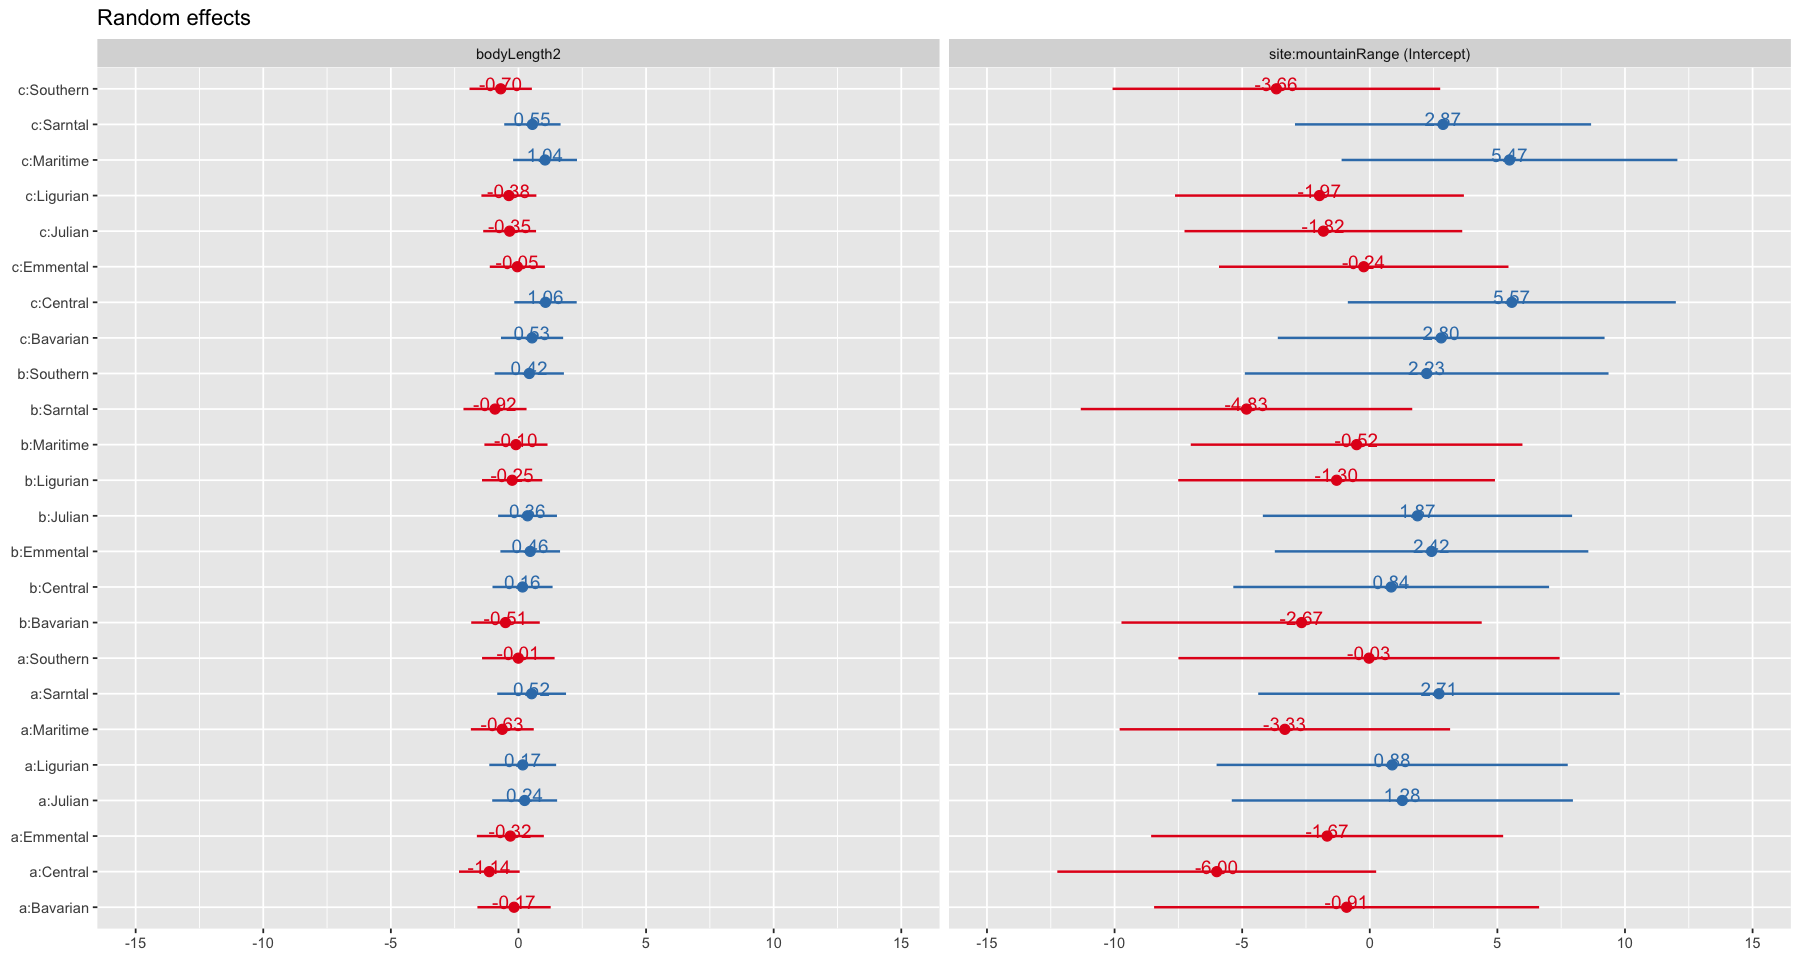

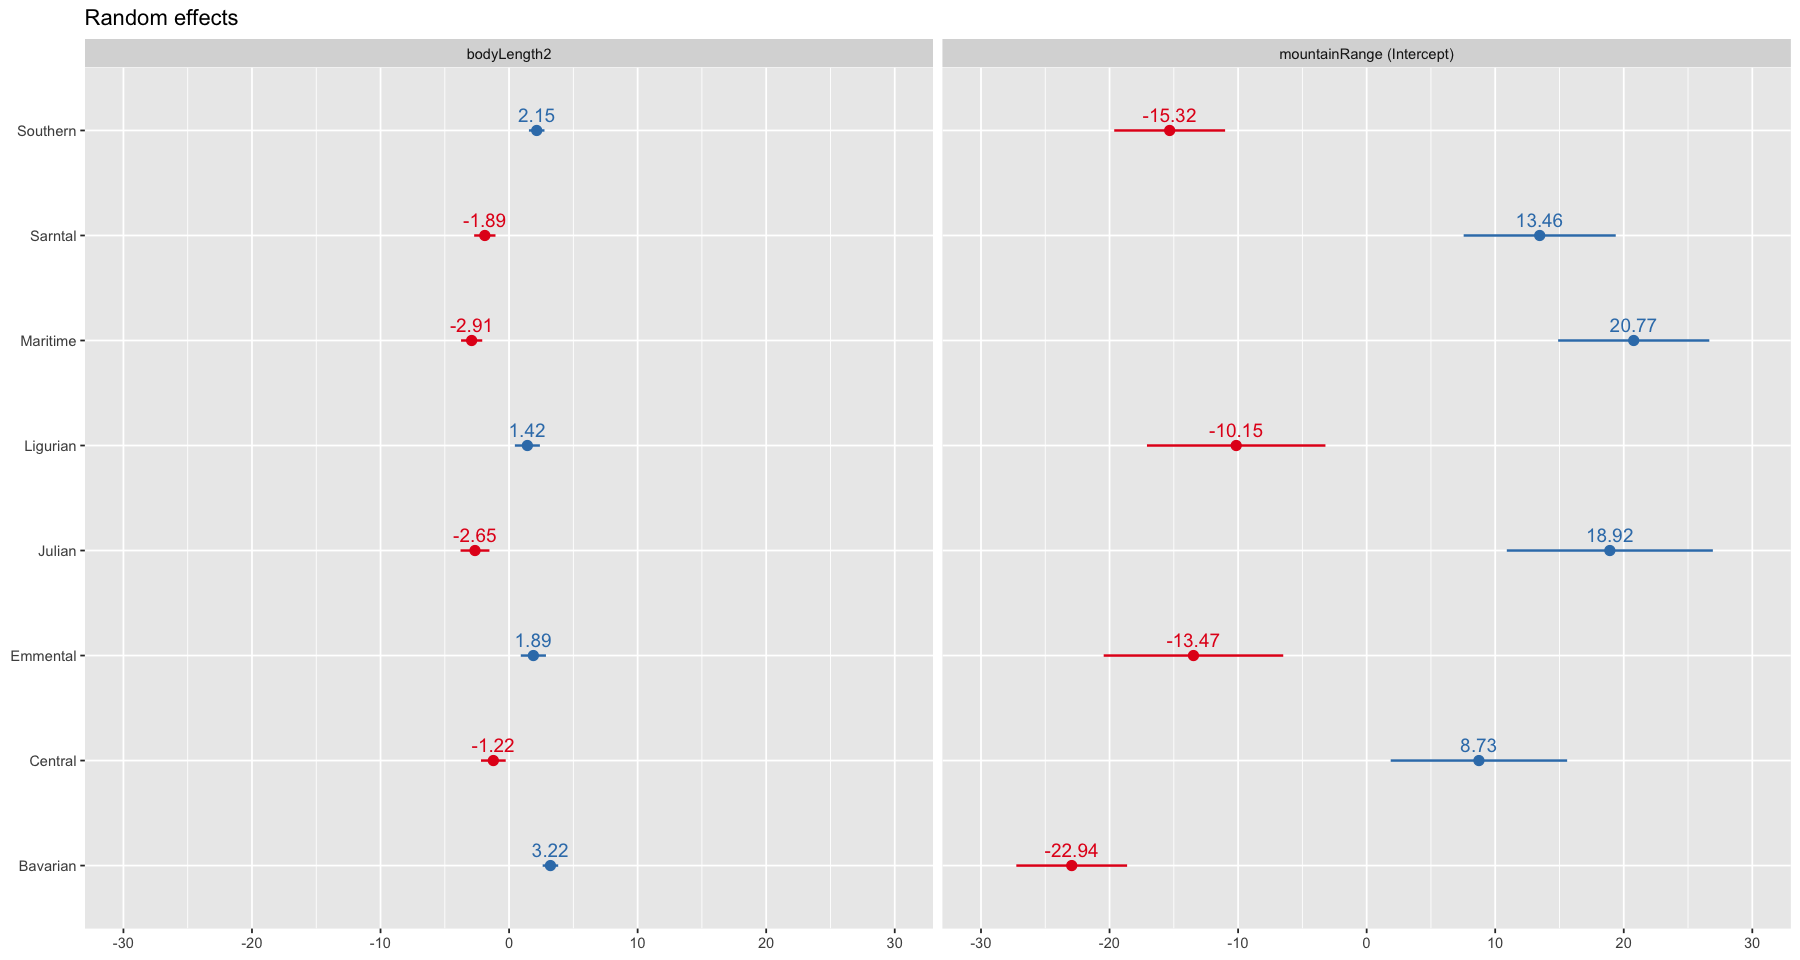

In [29]:
library(sjPlot)

# Visualise random effects 
(re.effects <- plot_model(mixed.ran_full, type = "re", show.values = TRUE))


Careful here! The values you see are NOT actual values, but rather the **difference between the general intercept or slope value found in your model summary and the estimate for this specific level of random effect**. For instance, the relationship for dragons in the Maritime mountain range would have a slope of (-2.91 + 0.67) = -2.24 and an intercept of (20.77 + 51.43) = 72.20.

## Table
https://www.jakeruss.com/cheatsheets/stargazer/

In [30]:
library(stargazer)
stargazer(mixed.lmer2, type = "text",
          digits = 3,
          star.cutoffs = c(0.05, 0.01, 0.001),
          digit.separator = "")


Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 





                         Dependent variable:     
                    -----------------------------
                              testScore          
-------------------------------------------------
bodyLength2                     0.831            
                               (1.681)           
                                                 
Constant                      50.386***          
                               (6.507)           
                                                 
-------------------------------------------------
Observations                     480             
Log Likelihood                -1985.195          
Akaike Inf. Crit.             3980.389           
Bayesian Inf. Crit.           4001.258           
Note:               *p<0.05; **p<0.01; ***p<0.001


In [31]:
# LaTeX format
library(stargazer)
stargazer(mixed.lmer2, type = "latex",
          digits = 3,
          star.cutoffs = c(0.05, 0.01, 0.001),
          digit.separator = "")


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Fri, Feb 03, 2023 - 20:35:01
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{1}{c}{\textit{Dependent variable:}} \\ 
\cline{2-2} 
\\[-1.8ex] & testScore \\ 
\hline \\[-1.8ex] 
 bodyLength2 & 0.831 \\ 
  & (1.681) \\ 
  & \\ 
 Constant & 50.386$^{***}$ \\ 
  & (6.507) \\ 
  & \\ 
\hline \\[-1.8ex] 
Observations & 480 \\ 
Log Likelihood & $-$1985.195 \\ 
Akaike Inf. Crit. & 3980.389 \\ 
Bayesian Inf. Crit. & 4001.258 \\ 
\hline 
\hline \\[-1.8ex] 
\textit{Note:}  & \multicolumn{1}{r}{$^{*}$p$<$0.05; $^{**}$p$<$0.01; $^{***}$p$<$0.001} \\ 
\end{tabular} 
\end{table} 


# 8. P-values and model selection

Please be very, very careful when it comes to model selection. Focus on your question, **don’t just plug in and drop variables from a model haphazardly until you make something “significant”**. Always choose variables based on biology/ecology: I might use model selection to check a couple of non-focal parameters, but I keep the “core” of the model untouched in most cases. **Define your goals and questions and focus on that.** Also, don’t just put all possible variables in (i.e. don’t overfit). **Remember that as a rule of thumb, you need 10 times more data than parameters you are trying to estimate.**

## Fixed effects structure

Most of you are probably going to be predominantly interested in your fixed effects, so let’s start here. `lme4` doesn’t spit out p-values for the parameters by default. **This is a conscious choice made by the authors of the package**, as there are many problems with p-values (I’m sure you are aware of the debates!).

You will inevitably look for a way to assess your model though so here are a few solutions on how to go about hypothesis testing in linear mixed models (LMMs):

Let’s have a quick go at likelihood ratio tests using `anova()`. With large sample sizes, p-values based on the likelihood ratio are generally considered okay. 

Fit the models, a full model and a reduced model in which we dropped our fixed effect (`bodyLength2`):

In [32]:
full.lmer <- lmer(testScore ~ bodyLength2 + (1|mountainRange) + (1|sample), data = dragons, REML = FALSE)
reduced.lmer <- lmer(testScore ~ 1 + (1|mountainRange) + (1|sample), data = dragons, REML = FALSE)
anova(reduced.lmer, full.lmer)  # the two models are not significantly different

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
reduced.lmer,4,3987.054,4003.749,-1989.527,3979.054,NA,NA,NA
full.lmer,5,3988.767,4009.636,-1989.384,3978.767,0.2867604,1,0.5923041


REML stands for restricted (or “residual”) maximum likelihood and it is the default parameter estimation criterion for linear mixed models. As you probably guessed, ML stands for maximum likelihood - you can set `REML = FALSE` in your call to `lmer` to use ML estimates. However, ML estimates are known to be biased and with REML being usually less biased, REML estimates of variance components are generally preferred. This is why in our previous models we skipped setting REML - we just left it as default (i.e. `REML = TRUE`).

REML assumes that the fixed effects structure is correct. You should use maximum likelihood when comparing models with different fixed effects, as ML doesn’t rely on the coefficients of the fixed effects - and that’s why we are refitting our full and reduced models above with the addition of `REML = FALSE` in the call.

Even though you use ML to compare models, you should report parameter estimates from your final “best” REML model, as ML may underestimate variance of the random effects.



## Random effects structure
Now you might wonder about selecting your random effects. In general, I’d advise you to think about your experimental design, your system and data collected, as well as your questions.

**If your random effects are there to deal with pseudoreplication, then it doesn’t really matter whether they are “significant” or not: they are part of your design and have to be included.** Imagine we tested our dragons multiple times - we then have to fit dragon identity as a random effect.

## Entire model selection
A few notes on the process of model selection. There are two ways here: (i) “top-down”, where you start with a complex model and gradually reduce it, and (ii) “step up”, where you start with a simple model and add new variables to it. Unfortunately, you might arrive at different final models by using those strategies and so you need to be careful.

The model selection process recommended by Zuur et al. (2009) is a top-down strategy and goes as follows:

1. fit a **full model** (he even recommends “beyond optimal” i.e. more complex than you’d expect or want it to be)
2. sort out the **random effects structure** (use REML likelihoods or REML AIC or BIC)
3. sort out **fixed effects structure** (either use REML the F-statistic or the t-statistic or compare nested ML models - keep your random effects constant)
4. once you arrive at the **final model present it using REML estimation**

NOTE: At the risk of sounding like a broken record: I think it’s best to decide on what your model is based on biology/ecology/data structure etc. than through following model selection blindly. Additionally, just because something is non-significant doesn’t necessarily mean you should always get rid of it.